Download data from "https://www.lendingclub.com/info/download-data.action" years 2007-2011.

In [4]:
%reset -f
from __future__ import division
import pandas as pd
import numpy as np

filename = '' #Write the filename of the original data set
df = pd.read_csv(filename, low_memory=False,skiprows=1)
col_names = df.columns.tolist()
print col_names
print 'Number of attributes: ' + str(len(col_names))

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code']
Number of attributes: 52


Case Study: we want to predict based on the information filled by the customer asking for a loan if it will be granted or not up to a certain threshold $thr$. We are using data from the Lending Club. Not all information is relevant to our interest, thus we detail in the following the fields we will base our prediction on:

+ annual_inc	The annual income provided by the borrower during registration.
+ delinq_2yrs	The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
+ dti	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
+ earliest_cr_line	The month the borrower's earliest reported credit line was opened
+ emp_length	Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
+ home_ownership	The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
+ installment	The monthly payment owed by the borrower if the loan originates.
+ int_rate	Interest Rate on the loan
+ is_inc_v	Indicates if income was verified by LC, not verified, or if the income source was verified
+ last_fico_range_high	The last upper boundary of range the borrower’s FICO belongs to pulled.
+ last_fico_range_low	The last lower boundary of range the borrower’s FICO belongs to pulled.
+ fico_range_high	The upper boundary of range the borrower’s FICO belongs to.
+ fico_range_low	The lower boundary of range the borrower’s FICO belongs to.
+ mths_since_last_delinq	The number of months since the borrower's last delinquency.
+ mths_since_last_major_derog	Months since most recent 90-day or worse rating
+ open_acc	The number of open credit lines in the borrower's credit file.
+ term	The number of payments on the loan. Values are in months and can be either 36 or 60.
+ total_acc	The total number of credit lines currently in the borrower's credit file
+ loan_amnt	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

We could work different scenarios:

+ Because we are given two datasets of rejected vs accepted we could work out the acceptance criterions
+ On the other hand we could try to predict successful accepted loans. A loan applicaiton is successful if the funded amount (funded_amnt) or the funded amount by investors (funded_amnt_inv) is close to the loan amount (loan_amnt) requested. In this sense we could put a threshold in which the acceptance is based on 
$$\frac{loan - funded}{loan}\geq 0.9$$

Let us focus for simplicity on this second case. Considering the accepted loans which ones are successful and can we derive some rules for success?


Let us drop the non-useful columns

In [5]:
drop_cols = ['id', 'member_id', 'grade', 'sub_grade','earliest_cr_line', 'emp_title', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'inq_last_6mths', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code']

In [6]:
df = df.drop(drop_cols,axis=1)

In [7]:
col_names = df.columns.tolist()
print col_names

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'dti', 'delinq_2yrs', 'mths_since_last_delinq', 'total_acc']


/Users/oriol/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Larger deviation: 7897
Total: 34638


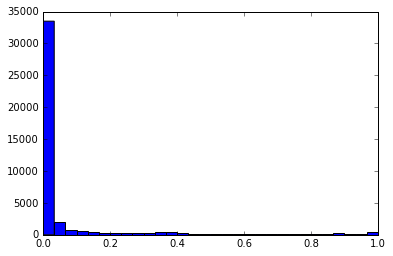

In [8]:
%matplotlib inline
loan = df['loan_amnt'].values
funded = df['funded_amnt_inv'].values
targets = np.abs(loan-funded)/loan

df['targets'] = targets
wrk_records = np.where(~np.isnan(targets))
y = targets[wrk_records]>=0.05

import matplotlib.pyplot as plt
plt.hist(targets[wrk_records],bins=30)

print 'Larger deviation: ' + str(np.sum(y))
print 'Total: ' + str(np.sum(1-y))

We stick to the accepted loans and try to predict if it will get the full amount by investors.

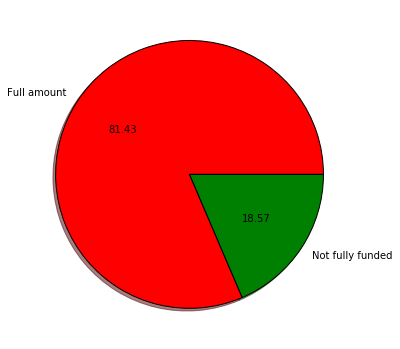

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.pie(np.c_[len(y)-np.sum(y),np.sum(y)][0],labels=['Full amount','Not fully funded'],colors=['r','g'],shadow=True,autopct ='%.2f' )
fig = plt.gcf()
fig.set_size_inches(6,6)


Check the features

In [10]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,dti,delinq_2yrs,mths_since_last_delinq,total_acc,targets
0,5000,5000,4975,36 months,10.65%,162.87,10+ years,RENT,24000,27.65,0,NaN,9,0.005
1,2500,2500,2500,60 months,15.27%,59.83,< 1 year,RENT,30000,1.00,0,NaN,4,0.000
2,2400,2400,2400,36 months,15.96%,84.33,10+ years,RENT,12252,8.72,0,NaN,10,0.000
3,10000,10000,10000,36 months,13.49%,339.31,10+ years,RENT,49200,20.00,0,35,37,0.000
4,3000,3000,3000,60 months,12.69%,67.79,1 year,RENT,80000,17.94,0,38,38,0.000


Observe the different issues in term, int_rate, emp_length, home_ownership. 

Interest rate is a string, so we may convert it to float by removing the percentage character and converting to float point values. With respect to term and emp_length we could use several strategies: we can vectorize the different results. But note that there is an order relationship. In this particular case categorical values can be directly translated to numbers that represent that order. Finally, house_ownership will be vectorized into as many features as values in the categorical variable.

In [11]:
def clear_percent (row):
    try:
        d = float(row['int_rate'][:-1])/100.
    except:
        d = None
    return d

df['int_rate_clean'] = df.apply (lambda row: clear_percent(row),axis=1)
    

In [12]:
print 'Values of the variable term: ' + str(np.unique(df['term']))

Values of the variable term: [nan ' 36 months' ' 60 months']


/Users/oriol/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [13]:
def clear_term (row):
    try:
        if row['term']==' 36 months':
            d = 1
        else:
            if row['term']==' 60 months':
                d = 2
            else:
                if np.isnan(row['term']):
                    d = None
                else:
                    print 'WRONG'
                    print row['term']
    except:
        print 'EXCEPT'
        d = None
    return d

df['term_clean'] = df.apply (lambda row: clear_term(row),axis=1)
    

In [14]:
print 'Values for employment length: ' + str(np.unique(df['emp_length']))

Values for employment length: [nan '1 year' '10+ years' '2 years' '3 years' '4 years' '5 years' '6 years'
 '7 years' '8 years' '9 years' '< 1 year' 'n/a']


In [15]:
#We use dictionary mapping as a switch 
def clean_emp_length(argument):
    switcher = {
        '1 year': 1,
        '2 years': 2,
        '3 years': 3,
        '4 years': 4,
        '5 years': 5,
        '6 years': 6,
        '7 years': 7,
        '8 years': 8,
        '9 years': 9,
        '10+ years': 10,
        '< 1 year': 0,
        'n/a':None,
    }
    try:
        d = switcher[argument['emp_length']]    
    except:
        d = None
    return d

df['emp_length_clean'] = df.apply (lambda row: clean_emp_length(row),axis=1)


In [16]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,dti,delinq_2yrs,mths_since_last_delinq,total_acc,targets,int_rate_clean,term_clean,emp_length_clean
0,5000,5000,4975,36 months,10.65%,162.87,10+ years,RENT,24000,27.65,0,NaN,9,0.005,0.1065,1,10
1,2500,2500,2500,60 months,15.27%,59.83,< 1 year,RENT,30000,1.00,0,NaN,4,0.000,0.1527,2,0
2,2400,2400,2400,36 months,15.96%,84.33,10+ years,RENT,12252,8.72,0,NaN,10,0.000,0.1596,1,10
3,10000,10000,10000,36 months,13.49%,339.31,10+ years,RENT,49200,20.00,0,35,37,0.000,0.1349,1,10
4,3000,3000,3000,60 months,12.69%,67.79,1 year,RENT,80000,17.94,0,38,38,0.000,0.1269,2,1


In [17]:
np.unique(df['home_ownership'])

array([nan, 'MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT'], dtype=object)

In [18]:
from sklearn.feature_extraction import DictVectorizer

comb_dict = df[['home_ownership']].to_dict(orient='records')
vec = DictVectorizer()
home = 2*vec.fit_transform(comb_dict).toarray()-1
home[:5]

array([[-1., -1., -1., -1., -1.,  1.],
       [-1., -1., -1., -1., -1.,  1.],
       [-1., -1., -1., -1., -1.,  1.],
       [-1., -1., -1., -1., -1.,  1.],
       [-1., -1., -1., -1., -1.,  1.]])

In [19]:
df_vector = pd.DataFrame(home[:,1:])
vector_columns = vec.get_feature_names()
df_vector.columns = vector_columns[1:]
df_vector.index = df.index
df_vector.head()


,home_ownership=MORTGAGE,home_ownership=NONE,home_ownership=OTHER,home_ownership=OWN,home_ownership=RENT
0,-1,-1,-1,-1,1
1,-1,-1,-1,-1,1
2,-1,-1,-1,-1,1
3,-1,-1,-1,-1,1
4,-1,-1,-1,-1,1


In [20]:
#Join data
df = df.join(df_vector)
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,dti,...,total_acc,targets,int_rate_clean,term_clean,emp_length_clean,home_ownership=MORTGAGE,home_ownership=NONE,home_ownership=OTHER,home_ownership=OWN,home_ownership=RENT
0,5000,5000,4975,36 months,10.65%,162.87,10+ years,RENT,24000,27.65,...,9,0.005,0.1065,1,10,-1,-1,-1,-1,1
1,2500,2500,2500,60 months,15.27%,59.83,< 1 year,RENT,30000,1.00,...,4,0.000,0.1527,2,0,-1,-1,-1,-1,1
2,2400,2400,2400,36 months,15.96%,84.33,10+ years,RENT,12252,8.72,...,10,0.000,0.1596,1,10,-1,-1,-1,-1,1
3,10000,10000,10000,36 months,13.49%,339.31,10+ years,RENT,49200,20.00,...,37,0.000,0.1349,1,10,-1,-1,-1,-1,1
4,3000,3000,3000,60 months,12.69%,67.79,1 year,RENT,80000,17.94,...,38,0.000,0.1269,2,1,-1,-1,-1,-1,1


In [21]:
#Drop processed columns
df = df.drop(['term','int_rate','emp_length','home_ownership'],axis=1)
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,mths_since_last_delinq,total_acc,targets,int_rate_clean,term_clean,emp_length_clean,home_ownership=MORTGAGE,home_ownership=NONE,home_ownership=OTHER,home_ownership=OWN,home_ownership=RENT
0,5000,5000,4975,162.87,24000,27.65,0,NaN,9,0.005,0.1065,1,10,-1,-1,-1,-1,1
1,2500,2500,2500,59.83,30000,1.00,0,NaN,4,0.000,0.1527,2,0,-1,-1,-1,-1,1
2,2400,2400,2400,84.33,12252,8.72,0,NaN,10,0.000,0.1596,1,10,-1,-1,-1,-1,1
3,10000,10000,10000,339.31,49200,20.00,0,35,37,0.000,0.1349,1,10,-1,-1,-1,-1,1
4,3000,3000,3000,67.79,80000,17.94,0,38,38,0.000,0.1269,2,1,-1,-1,-1,-1,1


In [22]:
#Drop the funded ammount
df=df.drop(['funded_amnt_inv'],axis=1)


In [23]:
#Declare targets
y = df['targets'].values>0.05
print 'Undefined values:' + str(np.sum(np.where(np.isnan(y),1,0)))
x=df.drop(['targets'],axis=1).values
idx_rmv = np.where(np.isnan(y))[0]
y = np.delete(y,idx_rmv)
x = np.delete(x,idx_rmv,axis=0)
print y.shape,x.shape

Undefined values:0
(42538,) (42538, 16)


array([    3,     3,     3,     7,     3,    32, 26929,    32,     3,
           3,  1115,     0,     0,     0,     0,     0])

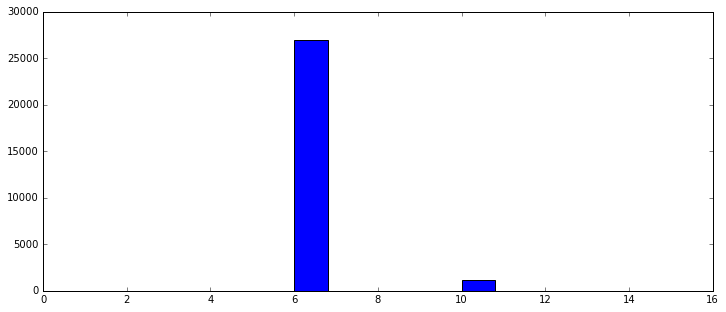

In [24]:
#Check what is going on in the data NaN
nan_feats=np.sum(np.where(np.isnan(x),1,0),axis=0)
plt.bar(np.arange(len(nan_feats)),nan_feats)
fig = plt.gcf()
fig.set_size_inches((12,5))
nan_feats

In [25]:
#Drop feature 6, too much NaN
print col_names[6]
x=np.hstack((x[:,:6],x[:,7:]))


emp_length


array([   3,    3,    3,    7,    3,   32,   32,    3,    3, 1115,    0,
          0,    0,    0,    0])

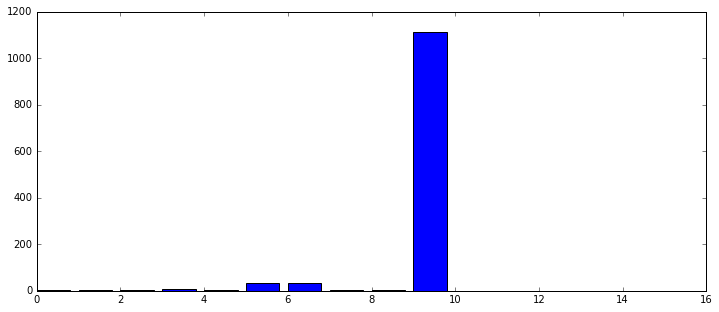

In [26]:
x.shape
#Check now
nan_feats=np.sum(np.where(np.isnan(x),1,0),axis=0)
plt.bar(np.arange(len(nan_feats)),nan_feats)
fig = plt.gcf()
fig.set_size_inches((12,5))
nan_feats

In [27]:
#Check records
nan_records=np.sum(np.where(np.isnan(x),1,0),axis=1)
np.histogram(nan_records)

(array([41394,  1112,    25,     4,     0,     0,     0,     0,     0,     3]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]))

We have all information from almost all members. Let us check the 1112 members and see if are from the minority class. 

In [28]:
print len(nan_records),len(y)
idx_rmv = np.where(nan_records>0)[0]
y = np.delete(y,idx_rmv)
x = np.delete(x,idx_rmv,axis=0)
print y.shape,x.shape

42538 42538
(41394,) (41394, 15)
